# Análise Comparativa

#### **Importando Bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_validate

#### **Leitura dos Dados**

In [2]:
df= pd.read_csv("../data/raw/wines_SPA.csv")
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [3]:
df_dict = pd.read_csv('../data/external/dictionary.csv')
df_dict

,variavel,descricao,tipo,subtipo
0,winery,Nome da vinícola,qualitativa,nominal
1,wine,Nome do vinho,qualitativa,nominal
2,year,Ano em que as uvas foram colhidas,quantitativa,discreta
3,rating,Avaliação média dada ao vinho pelos usuários [...,quantitativa,contínua
4,num_reviews,Número de usuários que avaliaram o vinho,quantitativa,discreta
5,country,País de origem [Espanha],inútil,inútil
6,region,Região do vinho,qualitativa,nominal
7,price,Preço em euros [€],quantitativa,contínua
8,type,Variedade de vinho,qualitativa,nominal
9,body,"Pontuação de corpo, definida como a riqueza e ...",qualitativa,ordinal


#### **Renomeando as colunas**

In [4]:
mapeamento_colunas = {
    'winery': 'vinícola',
    'wine': 'vinho',
    'year': 'ano',
    'rating': 'avaliação',
    'num_reviews': 'num_avaliações',
    'country': 'país',
    'region': 'região',
    'price': 'preço',
    'type': 'tipo',
    'body': 'corpo',
    'acidity': 'acidez'
}

In [5]:
def renomear_colunas(df, mapping):
    df.rename(columns=mapping, inplace=True)
    return df

In [6]:
df_dict['variavel'] = df_dict['variavel'].replace(mapeamento_colunas)
df = renomear_colunas(df, mapeamento_colunas)

## 1. Tratamento e Transformação de dados

#### **Verificando os Valores Faltantes e Dados Duplicados**

In [7]:
print(df.duplicated().sum())

5452


In [8]:
df = df.drop(df[df.duplicated()].index, axis=0)
df.reset_index()
print(f'Número de Duplicados: {df.duplicated().sum()}')

Número de Duplicados: 0


In [9]:
df['ano'] = df['ano'].replace('N.V.', np.nan)
df['ano'] = df['ano'].astype(pd.Int64Dtype())

In [10]:
print(f'Verificando valores faltantes : \n\n{df.isna().sum()}')

Verificando valores faltantes : 

vinícola            0
vinho               0
ano                72
avaliação           0
num_avaliações      0
país                0
região              0
preço               0
tipo              106
corpo             271
acidez            271
dtype: int64


#### **Verificando os Valores Discrepantes**

In [11]:
# Função para identificar outliers usando o IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # Primeiro quartil
    Q3 = df[column].quantile(0.75)  # Terceiro quartil
    IQR = Q3 - Q1                     # Intervalo Interquartil
    
    lower_bound = Q1 - 1.5 * IQR      # Limite inferior
    upper_bound = Q3 + 1.5 * IQR      # Limite superior
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [12]:
# Detectando outliers apenas para colunas numéricas
outliers_summary = []

for col in df.select_dtypes(include=[np.number]).columns:  # Filtra apenas colunas numéricas
    outliers = detect_outliers_iqr(df, col)
    if not outliers.empty:
        outliers_summary.append({'Coluna': col, 'Quantidade de Outliers': len(outliers)})

outliers_df = pd.DataFrame(outliers_summary)

print(outliers_df)

           Coluna  Quantidade de Outliers
0             ano                     165
1       avaliação                       2
2  num_avaliações                     242
3           preço                     245
4           corpo                      34
5          acidez                     105


In [13]:
df['preço'] = np.log1p(df['preço'])

## 2. Pré-Processamento dos Dados

#### **Definição das Variáveis do Modelo de Previsão**

In [14]:
# Variável alvo
target_variable = 'preço'

# Variáveis inúteis
useless_variables = (
    df_dict
    .query("tipo == 'inútil'")
    .variavel
    .to_list()
)

# Variáveis nominais
nominal_variables = (
    df_dict
    .query("subtipo == 'nominal' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis ordinais
ordinal_variables = (
    df_dict
    .query("subtipo == 'ordinal' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis contínuas
continuous_variables = (
    df_dict
    .query("subtipo == 'contínua' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis discretas
discrete_variables = (
    df_dict
    .query("subtipo == 'discreta' and variavel != @target_variable")
    .variavel
    .to_list()
)

In [15]:
X = df.drop(columns=[target_variable] + useless_variables)
y = df[target_variable]

In [16]:
# Exibindo as categorias de variáveis
print("Nominal Variables:", nominal_variables)
print("Ordinal Variables:", ordinal_variables)
print("Continuous Variables:", continuous_variables)
print("Discrete Variables:", discrete_variables)

Nominal Variables: ['vinícola', 'vinho', 'região', 'tipo']
Ordinal Variables: ['corpo', 'acidez']
Continuous Variables: ['avaliação']
Discrete Variables: ['ano', 'num_avaliações']


#### **Pré-processamento das Variáveis: Imputação e Codificação**

In [17]:
# Nominal variables: imputação de valores faltantes e codificação one-hot
nominal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy="most_frequent")),  # Preenchimento com o valor mais frequente
    ("encoding", OneHotEncoder(sparse_output=False, handle_unknown="infrequent_if_exist"))  # Codificação One-Hot
])

# Ordinal variables: imputação de valores faltantes e codificação ordinal
ordinal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy="median")),  # Preenchimento com a mediana
    ("encoding", OrdinalEncoder())  # Codificação ordinal
])

# Continuous variables: imputação de valores faltantes e normalização
continuous_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy="mean")),  # Preenchimento com a média
    ("normalization", StandardScaler())  # Normalização
])

# Discrete variables: imputação de valores faltantes e normalização
discrete_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy="median")),  # Preenchimento baseado em K vizinhos mais próximos
    ("normalization", StandardScaler())  # Normalização
])

In [18]:
# Criação do ColumnTransformer para processar cada tipo de variável
preprocessor = ColumnTransformer([
    ("nominal", nominal_preprocessor, nominal_variables),   
    ("ordinal", ordinal_preprocessor, ordinal_variables),   
    ("continuous", continuous_preprocessor, continuous_variables),  
    ("discrete", discrete_preprocessor, discrete_variables), 
])

In [19]:
preprocessor

ColumnTransformer(transformers=[('nominal',
                                 Pipeline(steps=[('missing',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False))]),
                                 ['vinícola', 'vinho', 'região', 'tipo']),
                                ('ordinal',
                                 Pipeline(steps=[('missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('encoding',
                                                  OrdinalEncoder())]),
                                 ['corpo', 'acidez']),
                                ('continuous',
                                 Pipeline(steps=[('missing', SimpleImputer()),
                                                 ('normalization',
                                                  StandardScaler())]),
                                 ['avaliação']),
                                ('discrete',
                                 Pipeline(steps=[('missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('normalization',
                                                  StandardScaler())]),
                                 ['ano', 'num_avaliações'])])

## 3. Avaliação e Comparação de Modelos

#### **Validação Cruzada e Métricas de Desempenho**

In [20]:
modelos = [DummyRegressor(strategy="mean"), LinearRegression(), SVR(), RandomForestRegressor(n_estimators=100, random_state=42)]

In [21]:
metricas = [
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_mean_absolute_percentage_error',
    'r2',
]

monte_carlo = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)

In [22]:
results_total = None
for modelo in modelos:
    model_name = modelo.__class__.__name__
    print(f"rodando para o modelo: {model_name}")
    approach = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('modelo', modelo),
    ])

    scores = cross_validate(
        approach, X, y,
        scoring=metricas, 
        cv=monte_carlo
    )
    results_model = pd.DataFrame(scores)
    results_model['Modelo'] = model_name
    if results_total is None:
        results_total = results_model
    else:
        results_total = pd.concat([results_total, results_model])

rodando para o modelo: DummyRegressor
rodando para o modelo: LinearRegression
rodando para o modelo: SVR
rodando para o modelo: RandomForestRegressor


In [23]:
# Renomear colunas
results_total = results_total.rename(
    columns={
        "fit_time": "Tempo de Treinamento",
        "score_time": "Tempo de Avaliação",
        "test_neg_mean_absolute_error": "Erro Absoluto Médio (Negativo)",
        "test_neg_mean_squared_error": "Erro Quadrático Médio (Negativo)",
        "test_neg_mean_absolute_percentage_error": "Erro Percentual Médio (Negativo)",
        "test_r2": "Coeficiente de Determinação (R²)",
        "Modelo": "Modelo"
    }
)

In [24]:
results_total.groupby('Modelo').agg(['mean', 'std']).T

Modelo                                 DummyRegressor  LinearRegression  \
Tempo de Treinamento             mean        0.134265      1.911930e+00   
                                 std         0.016178      6.369811e-01   
Tempo de Avaliação               mean        0.054102      2.831066e-02   
                                 std         0.010923      2.820680e-03   
Erro Absoluto Médio (Negativo)   mean       -0.792764     -9.324610e+10   
                                 std         0.027047      8.202604e+10   
Erro Quadrático Médio (Negativo) mean       -1.054131     -1.062371e+23   
                                 std         0.077255      1.056937e+23   
Erro Percentual Médio (Negativo) mean       -0.193789     -2.663961e+10   
                                 std         0.008106      2.326120e+10   
Coeficiente de Determinação (R²) mean       -0.001687     -1.024013e+23   
                                 std         0.002000      1.059492e+23   

Modelo                                 RandomForestRegressor       SVR  
Tempo de Treinamento             mean               9.756336  3.803828  
                                 std                2.581140  1.246293  
Tempo de Avaliação               mean               0.056607  1.296007  
                                 std                0.018491  0.469401  
Erro Absoluto Médio (Negativo)   mean              -0.374220 -0.336210  
                                 std                0.013652  0.010954  
Erro Quadrático Médio (Negativo) mean              -0.258897 -0.213778  
                                 std                0.021582  0.017288  
Erro Percentual Médio (Negativo) mean              -0.091684 -0.082441  
                                 std                0.003643  0.003075  
Coeficiente de Determinação (R²) mean               0.753764  0.796460  
                                 std                0.014106  0.014804

In [25]:
resultado_agregado = results_total.groupby('Modelo').agg(['mean', 'std']).T
resultado_agregado.columns

Index(['DummyRegressor', 'LinearRegression', 'RandomForestRegressor', 'SVR'], dtype='object', name='Modelo')

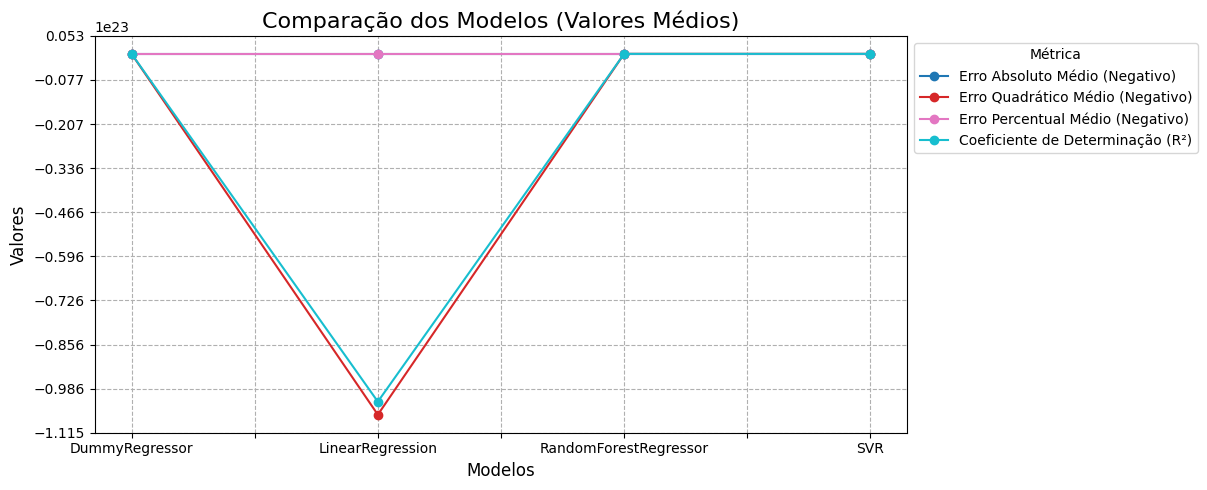

In [26]:
resultado_agregado_mean = resultado_agregado.xs('mean', level=1, axis=0).drop(index=['Tempo de Treinamento', 'Tempo de Avaliação'])

fig, ax = plt.subplots(figsize=(12, 5))
resultado_agregado_mean.T.plot(kind='line', marker='o', ax=ax, cmap='tab10', alpha=1.0)

ax.set_title("Comparação dos Modelos (Valores Médios)", fontsize=16)
ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)
ax.legend(title="Métrica", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* **DummyRegressor:**
    * Serviu como baseline. Apresentou baixos valores de R², indicando incapacidade de capturar relações entre as variáveis.
    * Erros elevados refletem seu desempenho básico esperado.

* **LinearRegression:**
    * Alto erro médio e valores extremamente negativos de R². Desempenho inconsistente para essa aplicação.

* **RandomForestRegressor:**
    * R² médio alto (~0.75), indicando bom ajuste.
    * Menores valores de erro absoluto e quadrático em relação aos outros modelos, mostrando maior precisão.

* **SVR:**
    * Melhor R² médio (~0.79), destacando-se como o modelo mais ajustado.
    * Baixos valores de erro médio, mostrando grande precisão.

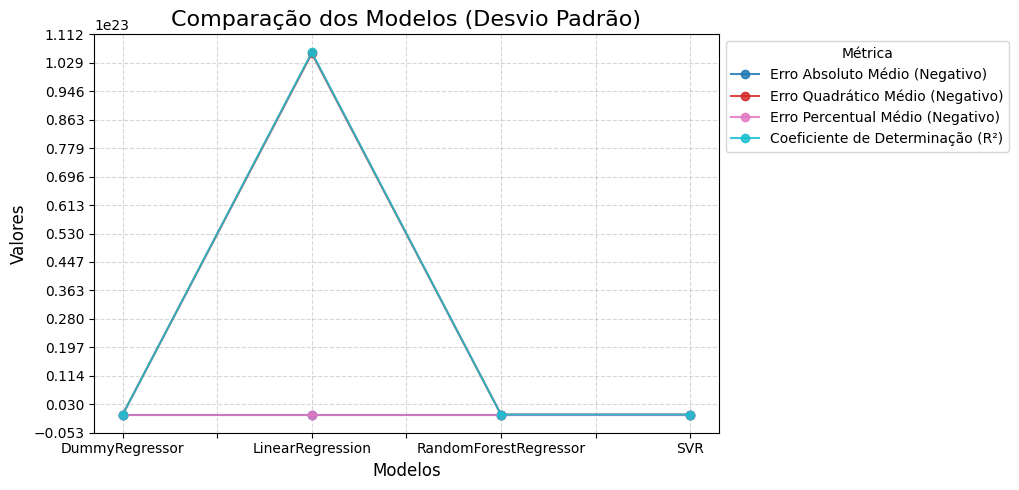

In [27]:
resultado_agregado_std = resultado_agregado.xs('std', level=1, axis=0).drop(index=['Tempo de Treinamento', 'Tempo de Avaliação'])

fig, ax = plt.subplots(figsize=(10, 5))
resultado_agregado_std.T.plot(kind='line', marker='o', ax=ax, cmap='tab10', alpha=0.85)

ax.set_title("Comparação dos Modelos (Desvio Padrão)", fontsize=16)
ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)
ax.legend(title="Métrica", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=15))

plt.show()

* **DummyRegressor:**
    * Baixa variabilidade nos erros e no R², refletindo a simplicidade do modelo.

* **LinearRegression:**
    * Elevada variabilidade nos erros e no R², sugerindo instabilidade e sensibilidade a variações nos dados.

*   **RandomForestRegressor:**
    * Variabilidade moderada nos erros e no R², indicando estabilidade no desempenho.

* **SVR:**
    * Menor variabilidade nos erros e no R², apontando consistência no desempenho.

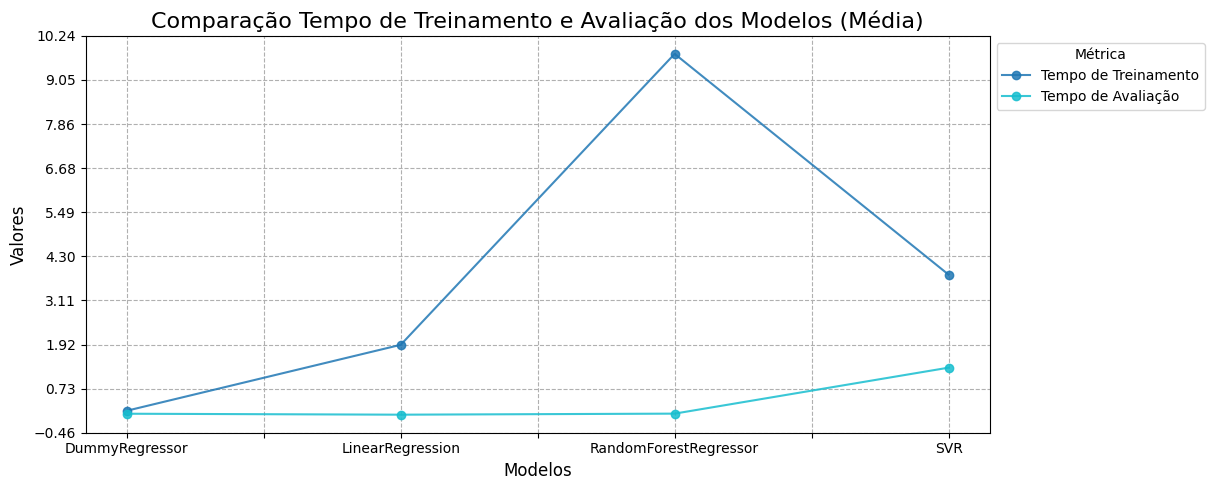

In [28]:
resultado_tempo_mean = resultado_agregado.xs('mean', level=1, axis=0).loc[['Tempo de Treinamento', 'Tempo de Avaliação']]

fig, ax = plt.subplots(figsize=(12, 5))
resultado_tempo_mean.T.plot(kind='line', marker='o', ax=ax, cmap='tab10', alpha=0.85)

ax.set_title("Comparação Tempo de Treinamento e Avaliação dos Modelos (Média)", fontsize=16)
ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)
ax.legend(title="Métrica", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* **DummyRegressor:**
    * Extremamente eficiente com o menor tempo de treinamento e avaliação, devido à simplicidade do modelo.

* **LinearRegression:**
    * Treinamento rápido, com tempo de avaliação semelhante ao do DummyRegressor, mostrando boa eficiência computacional.

* **RandomForestRegressor:**
    * Tempo de treinamento significativamente maior, devido ao uso de árvores de decisão em conjunto.
    * Tempo de avaliação um pouco mais elevado.

* **SVR:**
    * Tempo de treinamento mais elevado que os modelos lineares, porém inferior ao RandomForest.
    * Tempo de avaliação consideravelmente alto, devido a complexidade do modelo.

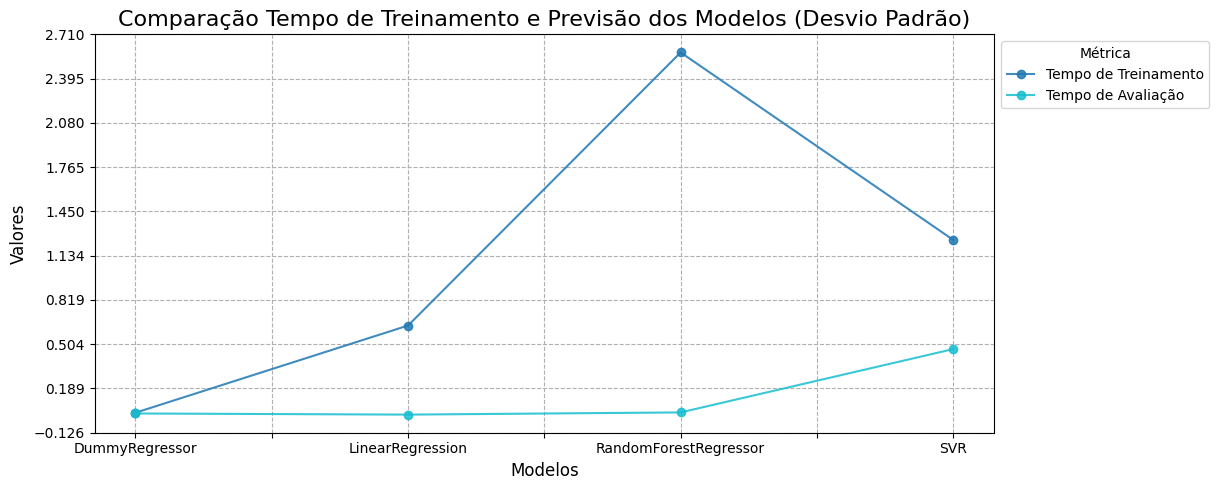

In [29]:
resultado_tempo_std = resultado_agregado.xs('std', level=1, axis=0).loc[['Tempo de Treinamento', 'Tempo de Avaliação']]

fig, ax = plt.subplots(figsize=(12, 5))
resultado_tempo_std.T.plot(kind='line', marker='o', ax=ax, cmap='tab10', alpha=0.85)

ax.set_title("Comparação Tempo de Treinamento e Previsão dos Modelos (Desvio Padrão)", fontsize=16)
ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)
ax.legend(title="Métrica", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* **DummyRegressor:**
    * Variabilidade muito baixa, como esperado para um modelo simples.

* **LinearRegression:**
    * Baixa variabilidade, indicando desempenho computacional consistente.

* **RandomForestRegressor:**
    * Variabilidade moderada no tempo de treinamento, devido à natureza do algoritmo baseado em árvores.

* **SVR:**
    * Variabilidade baixa no treinamento, mas maior na avaliação, devido à complexidade do modelo com diferentes conjuntos de dados.

#### **Predição do Modelo**

Divisão de treino e teste

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Aplicar o pré-processador aos dados de treino e teste
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [32]:
# Verificando o tamanho dos dados transformados
print("Shape of X_train_transformed:", X_train_transformed.shape)
print("Shape of X_test_transformed:", X_test_transformed.shape)

Shape of X_train_transformed: (1638, 1268)
Shape of X_test_transformed: (410, 1268)


In [33]:
# Dicionário para armazenar os modelos treinados
trained_models = {}
# Treinando os modelos com os dados transformados
for model in modelos:
    model_name = type(model).__name__
    model.fit(X_train_transformed, y_train)
    trained_models[model_name] = model

In [34]:
#df['preço'] = np.expm1(df['preço'])
# Fazendo predições
predictions = {}
for model_name, trained_model in trained_models.items():
    y_pred = trained_model.predict(X_test_transformed)
    predictions[model_name] = y_pred
    print(f"Predictions for {model_name}:")
    print(y_pred[:5])  # Exibindo as primeiras 5 predições

Predictions for DummyRegressor:
[4.17956997 4.17956997 4.17956997 4.17956997 4.17956997]
Predictions for LinearRegression:
[8.47527392e+09 4.05978417e+00 7.43184447e+00 4.62033057e+00
 4.05875373e+00]
Predictions for SVR:
[3.42159783 3.78997048 7.22446071 4.50556286 3.40738925]
Predictions for RandomForestRegressor:
[3.72484582 3.96430207 7.02458752 4.53668817 3.49149499]


## 4. Conclusão da Análise

* **Tempo de Treinamento e Previsão:** O DummyRegressor se destacou como o modelo mais rápido para treinamento, devido à sua simplicidade, enquanto o SVR teve o tempo de avaliação mais elevado entre os modelos, embora ainda viável. No entanto, foi o modelo que apresentou o melhor desempenho geral em termos de erro e R².

* **Desempenho (Erro e R²):** O SVR apresentou os melhores resultados em termos de erro (MAE, MSE e MAPE) e capacidade de explicação da variância dos dados, com um R² de 0.796460. Isso indica que o SVR se ajustou bem aos dados e conseguiu explicar uma parte considerável da variação observada, destacando-se como o modelo mais ajustado entre os testados.

* **Conclusão Geral:** O SVR foi o modelo mais robusto, com excelente desempenho em todas as métricas de erro e capacidade de explicação dos dados. Por outro lado, o DummyRegressor, embora rápido, não apresentou um bom ajuste aos dados, funcionando apenas como uma linha de base simples. O SVR é a melhor escolha entre os modelos testados, principalmente quando a precisão e a explicação da variância dos dados são fundamentais.

| **Métrica**              | **Melhor Modelo**     | **Justificativa**                                                                 |
|--------------------------|-----------------------|-----------------------------------------------------------------------------------|
| **Tempo de Treinamento** | DummyRegressor        | É o mais rápido de treinar, já que apenas calcula a média.                       |
| **Tempo de Previsão**    | DummyRegressor        | É o mais rápido para realizar predições, devido à sua simplicidade.             |
| **MAE, MSE e MAPE**      | SVR                   | Apresentou os menores erros em todas as métricas.                                |
| **R²**                   | SVR                   | Melhor capacidade de explicação da variância dos dados, com um R² de 0.796460.   |
